In [28]:
import base64
from IPython.display import HTML
import json
import pandas as pd
import sys
import time
import datetime
from IPython.display import Markdown
import matplotlib.pyplot as plt

In [29]:
def durationWithUnit(timeOrCount, type):
    durationWithUnit=str(timeOrCount)
    if batch['Tests']['type']=='duration':
        return durationWithUnit+ ' sec'
    else:
        return durationSingleTest + ' requests'

In [30]:
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [31]:
def addCommonData(resultData):
    resultData['Deployment']=deployment
    resultData['Total CPUs']=totalCPUs
    resultData['Total Memory GB']=totalMemoryGB
    resultData['Duration Single Test']=durationSingleTest
    resultData['Persistence']=persistence
    resultData['App Process URL']=appProcessUrl

In [32]:
batch=json.load(open('test-run/batch.json'))
# print(batch)

In [33]:
# TODO: restore once usage is available
# systemDataName='test-run/results/system-data.csv'
systemDataName='system-data.csv'
systemData = pd.read_csv(systemDataName, names=['totalCPUs', 'totalMemoryGB'],header=0, index_col=False)
totalCPUs=systemData.totalCPUs[0]
totalMemoryGB=systemData.totalMemoryGB[0]

In [34]:
tester=batch['InfraSetup']['tester']
app=batch['InfraSetup']['app']
localHosts=['LOCAL','VM1','VM2']
deployment='On-premise' if (tester['name'] in localHosts and app['name'] in localHosts) else 'Cloud'

appInfra=batch['AppInfra']
persistence='Mongo' if appInfra['Mongo']=='yes' else 'PostgresQL' if appInfra['PostgresQL']=='yes' else 'None'
appProcess=batch['Process']
appProcessUrl=appProcess['schema']+"://"+appProcess['url']+':'+str(appProcess['port'])+'/'+appProcess['app']

durationSingleTest=durationWithUnit(batch['Tests']['timeOrCount'], batch['Tests']['type'])

# TODO: can we fetch this together with the CPU/Memory system details?
jdkVersion='openjdk 11.0.10 2021-01-19'
# TODO: do we want to model test engin in batch.json?
testEngine='JMeter'

warmup='no' if batch['Warmup']=="no" else durationWithUnit(batch['Warmup']['timeOrCount'], batch['Warmup']['type'])


In [35]:
testResults=[]
counter=0
minTimestamp=sys.maxsize
maxTimestamp=0
for test in batch['Tests']['runs']:
    csvName='test-run/results/res'+str(counter)+'.csv'
    result = pd.read_csv(csvName, header=0, index_col=False)
    # print(result)
    resultData={}
    addCommonData(resultData)
    resultData['#Replicas']=test['replicas']
    resultData['#Users']=test['users']
    resultData['MRT(ms)']=result.Average[0]
    resultData['RPS']=result.Throughput[0]
    # print(resultData)

    # TODO: restore once usage is available
    # usageName='test-run/results/usage'+str(counter)+'.csv'
    usageName='usageN.csv'
    usage = pd.read_csv(usageName, 
        names=['appCpuUsage', 'systemCpuUsage', 'appMemoryUsage', 'appMemoryUsagePercentage', 'systemMemoryUsage', 'systemMemoryUsagePercentage'],
        header=0, index_col=False)
    resultData['CPU Usage-app']=usage.appCpuUsage[0]
    resultData['CPU Usage-system']=usage.systemCpuUsage[0]
    resultData['Memory Usage-app']=usage.appMemoryUsage[0]
    resultData['Memory Usage%-app']=usage.appMemoryUsagePercentage[0]
    resultData['Memory Usage-system']=usage.systemMemoryUsage[0]
    resultData['Memory Usage%-system']=usage.systemMemoryUsagePercentage[0]

    # print(resultData)
    testResults.append(resultData)

    jtlName='test-run/results/res'+str(counter)+'.jtl'
    jtl = pd.read_csv(jtlName, header=0, index_col=False)
    minTimestamp=min([minTimestamp, jtl.timeStamp[0]])
    maxTimestamp=max([maxTimestamp, jtl.timeStamp[len(jtl)-1]])

    counter=counter+1

# print(testResults)

In [36]:
startTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(minTimestamp/1000))
endTime=time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(maxTimestamp/1000))
batchDuration=str(datetime.timedelta(seconds=(maxTimestamp/1000-minTimestamp/1000)))


In [69]:
Markdown("""
# Kogito Benchmart Report
## Test Environment
* Deployment:  {deployment}
* Execution time: Started {startTime}, ended {endTime})
* Duration:  {batchDuration}
* Duration of each test:  {durationSingleTest}
* Warmup: {warmup}
* Persistence: {persistence}
* Process: {appProcessUrl}
""".format(startTime=startTime, 
    endTime=endTime,batchDuration=batchDuration,
    deployment=deployment, durationSingleTest=durationSingleTest, warmup=warmup,
    persistence=persistence, appProcessUrl=appProcessUrl))




# Kogito Benchmart Report
## Test Environment
* Deployment:  On-premise
* Execution time: Started 2021-10-28 18:02:03, ended 2021-10-28 18:52:33)
* Duration:  0:50:30.654000
* Duration of each test:  120 sec
* Warmup: 60 sec
* Persistence: Mongo
* Process: http://localhost:8080/simpleHT


In [38]:
Markdown("""
## Test Client
* Client host: {hostname}
* Test engine:  {testEngine}
""".format(hostname=tester['hostname'], testEngine=testEngine, durationSingleTest=durationSingleTest))



## Test Client
* Client host: localhost
* Test engine:  JMeter


In [39]:
Markdown("""
## Test Service
* Service host: {hostname} ({totalCPUs} CPU cores, {totalMemoryGB} GB Memory)
* Test engine:  {testEngine}
* JDK version:  {jdkVersion}
* Kogito version: {appVersion}
""".format(hostname=app['hostname'], totalCPUs=totalCPUs, totalMemoryGB=totalMemoryGB,
    testEngine=testEngine, jdkVersion=jdkVersion,
    appVersion=batch['InfraSetup']['appVersion']))



## Test Service
* Service host: localhost (4 CPU cores, 16 GB Memory)
* Test engine:  JMeter
* JDK version:  openjdk 11.0.10 2021-01-19
* Kogito version: CoreFix-mem-idx-2.0.0-snap


## Execution Report
### Chart view

In [40]:
raw = pd.DataFrame(testResults)
# print(raw)

In [41]:
raw.insert(1,'Start Time', startTime)
raw.insert(2,'End Time', endTime)
raw.insert(3,'Batch Duration', batchDuration)


In [42]:
users = raw['#Users'].unique()
# print(users)

In [43]:
mrt = {}
for r in raw['#Replicas'].unique():
    mrtValues = raw[raw['#Replicas']==r]['MRT(ms)'].values
    mrt['MRT#'+str(r)] = mrtValues
# print(mrt)

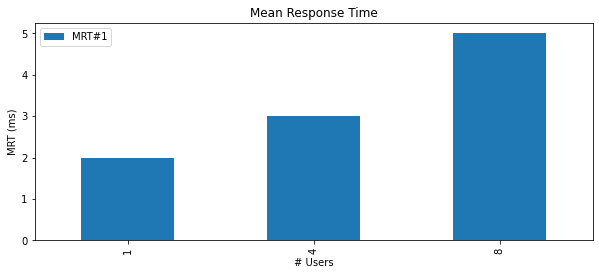

In [44]:
plt.rcParams["figure.figsize"] = (10,4)

mrtDF = pd.DataFrame(mrt, index=users)

mrtDF.plot(kind="bar")
plt.title("Mean Response Time")
plt.xlabel("# Users")
plt.ylabel("MRT (ms)")
plt.rcParams["figure.figsize"] = (10,4)


In [45]:
rps = {}
for r in raw['#Replicas'].unique():
    rpsValues = raw[raw['#Replicas']==r]['RPS'].values
    rps['RPS#'+str(r)] = rpsValues

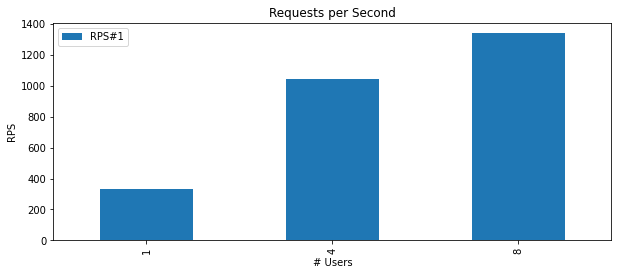

In [46]:
mrtDF = pd.DataFrame(rps, index=users)

mrtDF.plot(kind="bar")
plt.title("Requests per Second")
plt.xlabel("# Users")
plt.ylabel("RPS")
plt.rcParams["figure.figsize"] = (10,4)

In [47]:
cpuUsage = {}
for r in raw['#Replicas'].unique():
    cpuUsageValues = raw[raw['#Replicas']==r]['CPU Usage-app'].str.replace('%','').apply(pd.to_numeric).values
    cpuUsage['CPU#'+str(r)] = cpuUsageValues

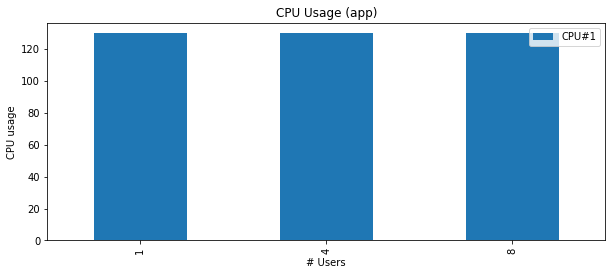

In [48]:
cpusDF = pd.DataFrame(cpuUsage, index=users)
# cpusDF.style
cpusDF.plot(kind="bar")
plt.title("CPU Usage (app)")
plt.xlabel("# Users")
plt.ylabel("CPU usage")
plt.rcParams["figure.figsize"] = (10,4)

In [51]:
memoryUsage = {}
for r in raw['#Replicas'].unique():
    memoryUsageValues = raw[raw['#Replicas']==r]['Memory Usage-app'].str.replace('GB','').apply(pd.to_numeric).values
    memoryUsage['Memory#'+str(r)] = memoryUsageValues

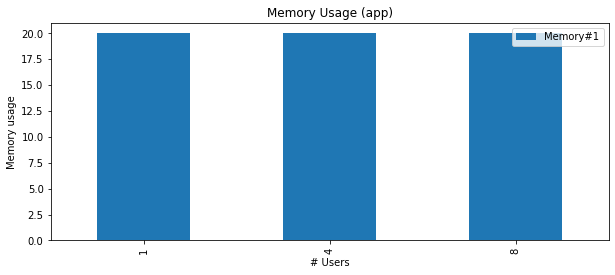

In [52]:
memoryUsageDF = pd.DataFrame(memoryUsage, index=users)
memoryUsageDF.plot(kind="bar")
plt.title("Memory Usage (app)")
plt.xlabel("# Users")
plt.ylabel("Memory usage")
plt.rcParams["figure.figsize"] = (10,4)

In [61]:
combinedUsage = {}
for r in raw['#Replicas'].unique():
    appCpuUsageValues = raw[raw['#Replicas']==r]['CPU Usage-app'].str.replace('%','').apply(pd.to_numeric).values
    systemCpuUsageValues = raw[raw['#Replicas']==r]['CPU Usage-system'].str.replace('%','').apply(pd.to_numeric).values
    appMemoryUsageValues = raw[raw['#Replicas']==r]['Memory Usage%-app'].str.replace('%','').apply(pd.to_numeric).values
    systemMemoryUsageValues = raw[raw['#Replicas']==r]['Memory Usage%-system'].str.replace('%','').apply(pd.to_numeric).values
    combinedUsage['CPU%-app#'+str(r)] = appCpuUsageValues
    combinedUsage['CPU%-sys#'+str(r)] = systemCpuUsageValues
    combinedUsage['Memory%-app#'+str(r)] = appMemoryUsageValues
    combinedUsage['Memory%-sys#'+str(r)] = systemMemoryUsageValues

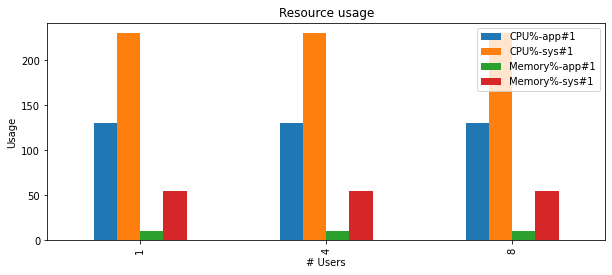

In [62]:
combinedUsageDF = pd.DataFrame(combinedUsage, index=users)
combinedUsageDF.plot(kind="bar")
plt.title("Resource usage")
plt.xlabel("# Users")
plt.ylabel("Usage")
plt.rcParams["figure.figsize"] = (10,4)

### Tabular view

In [55]:
raw.style.hide_index().hide_columns(['Total CPUs', 'Total Memory GB', 'Start Time', 'End Time', 'Batch Duration',
    'Duration Single Test', 'App Process URL', 'CPU Usage-system', 'Memory Usage-system','Memory Usage%-system'])

Deployment,Persistence,#Replicas,#Users,MRT(ms),RPS,CPU Usage-app,Memory Usage-app,Memory Usage%-app
On-premise,Mongo,1,1,2,331.400000,130%,20GB,10.5%
On-premise,Mongo,1,4,3,1045.800000,130%,20GB,10.5%
On-premise,Mongo,1,8,5,1339.100000,130%,20GB,10.5%


In [56]:
downloadName=(deployment+'_'+startTime+'.csv').replace(':',"_").replace(' ',"_")
create_download_link(df=raw, filename=downloadName, title='Download detailed CSV report')